# Denoising Score Matching(DSM) Notebook
- This notebook is for learning the DSM method and use this loss function to learn the distribution of the data.
- We will discuss the following topics:
    - One-step score matching
    - Score matching with different original distribution
    - Score matching in higher dimension
    - Score matching in a stochastic process
        - Ornstein-Uhlenbeck process
        - Sampling from Ornstein-Uhlenbeck process
    

# 0. Background Settings
This is the library we will use in this notebook

In [29]:
import jax
import jaxgeometry
import diffrax
import jax.random as jrandom
from jax import numpy as jnp
import flax
import flax.linen as nn
import optax
import numpy as np
import random
from flax.training import train_state
from functools import partial
import matplotlib.pyplot as plt

Random seed settings and key generator

In [30]:
seed = 0
rand_seed = random.randint(0, 1000000)
globe_key = jrandom.PRNGKey(rand_seed)
def key_gen():
    global globe_key
    new_key, subkey = jrandom.split(globe_key)
    globe_key = new_key
    return subkey


# 1. One-step score matching

In [31]:
def add_noise(key, x, sigma=0.1):
    key, subkey = jrandom.split(key)
    return x + sigma * jrandom.normal(subkey, x.shape)


class Onestep_score_MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=2)(x)
        x = nn.leaky_relu(x)
        
        return x
    
    

In [32]:
def init_train_state_onestep(key, model, x) ->train_state.TrainState:
    params = model.init(key, x)
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

@partial(jax.jit, static_argnums=(2,3))
def update_step(key, state, sigma, sample_size):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.normal(subkey, (sample_size, 2))* 0.5 +1
    # batch_x = jrandom.uniform(subkey, (sample_size, 2)) * 8 - 4
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step(subkey,state, sigma, sample_size)
    if i % 1000 == 0:
        print(loss)
    
    

95.32802
105.21424
99.34158
94.71344
97.354065
95.92554
99.96369
95.89741
94.05126
99.99499


### Plot the learned distribution on the 2D plane
The red arrows are gradients of the learned distribution and the original distribution is a 2D Gaussian distribution.

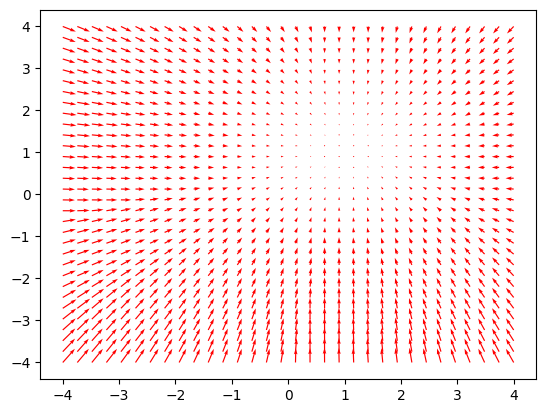

In [33]:
X, Y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')
plt.show()

# 2. Score matching with different original distribution
People can use different original distribution to learn the distribution of the data. Here we will show the score matching method on different original distribution.

In [34]:
@partial(jax.jit, static_argnums=(2,3,4))
def update_step_mixture_gaussian(key, state, sigma, sample_size, num_mixture=2, mixture_weight=jnp.array([0.5, 0.5]), mixture_mean=jnp.array([-2, 2]), mixture_std=jnp.array([0.5, 0.5])):
    # test the sum of the mixture weight
    # assert jnp.sum(mixture_weight) == 1
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    key, subkey = jrandom.split(key)
    batch_x = jrandom.normal(subkey, (sample_size, 2)) * mixture_std[compoent] + mixture_mean[compoent]
    # batch_x = jrandom.uniform(subkey, (sample_size, 2)) * 8 - 4
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

In [35]:
model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_mixture_gaussian(subkey,state, sigma, sample_size, num_mixture=3, mixture_weight=jnp.array([0.8, 0.1, 0.1]), mixture_mean=jnp.array([-2, 2, 0]), mixture_std=jnp.array([0.5, 0.5, 0.5]))
    if i % 1000 == 0:
        print(loss)

96.56914
96.65793
97.30691
100.95393
92.06233
93.76875
88.9418
103.36099
89.2948
96.79274


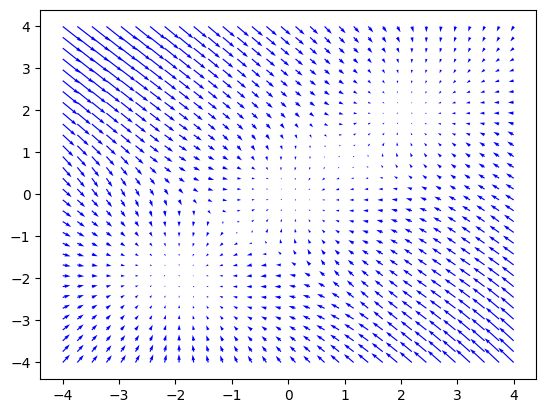

In [36]:
X, Y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()

## 2.1 Sample given numbers of centers, std and mixture weight to generate the data

In [37]:
# sample the hyperparameters
def sample_hyperparameter(key, num_mixture=2):
    key, subkey = jrandom.split(key)
    mixture_weight = jrandom.dirichlet(subkey, jnp.ones(num_mixture))
    key, subkey = jrandom.split(key)
    mean_xs = jrandom.uniform(subkey, (num_mixture, 1)) * 10 - 5
    key, subkey = jrandom.split(key)
    mean_ys = jrandom.uniform(subkey, (num_mixture, 1)) * 10 - 5
    key, subkey = jrandom.split(key)
    stds = jrandom.uniform(subkey, (num_mixture, 2)) *1 + 0.5
    means = jnp.stack([mean_xs, mean_ys], axis=-1)
    return mixture_weight, means, stds, key

def sample_mixture_gaussian(key,num_mixture, sample_size, mixture_weight=None, means=None, stds=None):
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    key, subkey = jrandom.split(key)
    stds = jnp.reshape(stds[compoent], (sample_size, 2))
    means = jnp.reshape(means[compoent], (sample_size, 2))
    print(stds)
    
    batch_x = jax.vmap(lambda mean, std: jnp.multiply(jrandom.normal(subkey, (2,)), std) + mean, in_axes=(0,0))(means, stds)
    return batch_x, mixture_weight, means, stds, key

@partial(jax.jit, static_argnums=(2,3,4))
def update_step_MG_random(key, state, sigma, sample_size, num_mixture, mixture_weight=jnp.array([0.5, 0.5]), means=jnp.array([[-2, 2], [2, -2]]), stds=jnp.array([[0.5, 0.5], [0.5, 0.5]])):
    batch_x, mixture_weight, means, stds, key = sample_mixture_gaussian(key,num_mixture, sample_size, mixture_weight, means, stds)
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
num_mixture = 2
mixture_weight, means, stds, subkey = sample_hyperparameter(subkey, num_mixture)
globe_key = subkey

for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_MG_random(subkey,state, sigma, sample_size, num_mixture, mixture_weight, means, stds)
    if i % 1000 == 0:
        print(loss)
    
print("Mixture weight: ", mixture_weight)
print("Mixture means: ", means)
print("Mixture stds: ", stds)
print("mixture covariance: ", jax.vmap(lambda std: jnp.diag(std**2), in_axes=(0))(stds))


Traced<ShapedArray(float32[500,2])>with<DynamicJaxprTrace(level=1/0)>
97.38211
98.26702
101.51083
93.60977
98.764885
106.740364
99.828255
97.29033
98.35644
102.264114
Mixture weight:  [0.5476809 0.4523191]
Mixture means:  [[[-4.5047903 -1.4442241]]

 [[-0.896307  -1.304549 ]]]
Mixture stds:  [[0.5832665  0.8803048 ]
 [1.3145986  0.76618254]]
mixture covariance:  [[[0.3401998  0.        ]
  [0.         0.77493656]]

 [[1.7281693  0.        ]
  [0.         0.5870357 ]]]


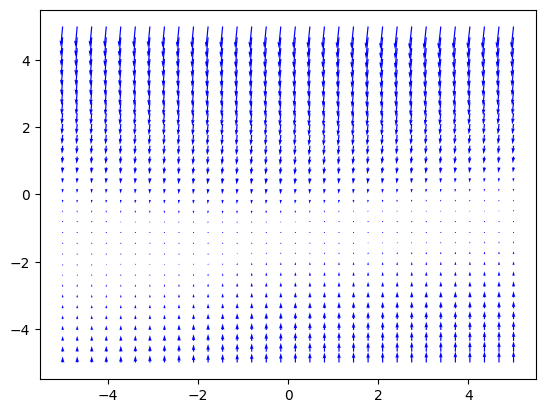

In [38]:
X, Y = jnp.meshgrid(jnp.linspace(-5, 5, 32), jnp.linspace(-5, 5, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()


## 2.2 Sample mixture gaussian that centers are on the circle

In [39]:
class MLP_for_circle(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=2)(x)
        x = nn.leaky_relu(x)
        
        return x

In [40]:
@partial(jax.jit, static_argnums=(0,1))
def circle_points(num_points, radius):
    angles = jnp.linspace(0, 2*jnp.pi, num_points+1)[:-1]
    print(angles)
    x = radius * jnp.cos(angles)
    y = radius * jnp.sin(angles)
    return jnp.stack([x, y], axis=-1)

@partial(jax.jit, static_argnums=(2,3,4,5))
def update_step_GM_circle(key, state, sigma, sample_size, num_mixture, radius=2):
    means = circle_points(num_mixture, radius)
    mixture_weight = jnp.ones(num_mixture) / num_mixture
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    keys = jrandom.split(key, sample_size)
    # keys = keys[:,0]
    # keys = keys.reshape((sample_size, -1))
    batched_x = jax.vmap(lambda mean, single_key: jrandom.normal(single_key, (2,)) * 0.5 + mean, in_axes=(0, 0))(means[compoent], keys )
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batched_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batched_x, batch_noised_x), axis=0)
    
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = MLP_for_circle()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 800
num_mixture = 8
radius = 2
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_GM_circle(subkey,state, sigma, sample_size, num_mixture, radius)
    if i % 1000 == 0:
        print(loss)

Traced<ShapedArray(float32[8])>with<DynamicJaxprTrace(level=2/0)>
97.34975
99.27763
94.45592
101.05609
106.396385
98.45774
93.089294
95.98087
104.42086
96.42673


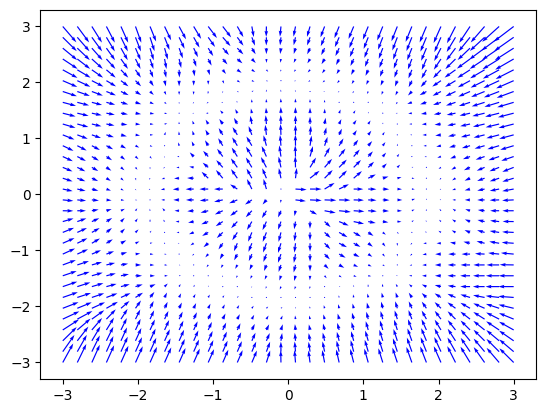

In [41]:
X, Y = jnp.meshgrid(jnp.linspace(-3, 3, 32), jnp.linspace(-3, 3, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()

Traced<ShapedArray(float32[8])>with<DynamicJaxprTrace(level=1/0)>
[[ 5.0000000e+00  0.0000000e+00]
 [ 3.5355339e+00  3.5355341e+00]
 [-2.1855695e-07  5.0000000e+00]
 [-3.5355339e+00  3.5355341e+00]
 [-5.0000000e+00 -4.3711390e-07]
 [-3.5355334e+00 -3.5355344e+00]
 [ 5.9624405e-08 -5.0000000e+00]
 [ 3.5355351e+00 -3.5355327e+00]]


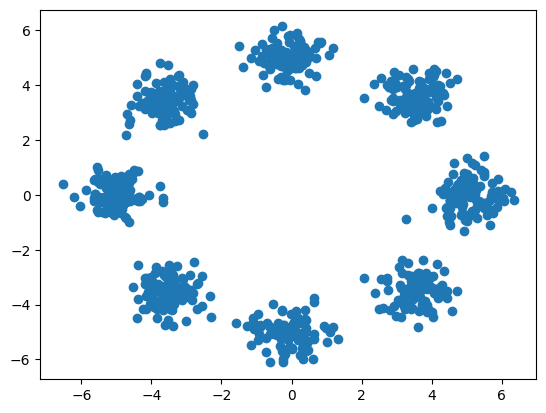

In [42]:
centers = circle_points(8, 5)
print(centers)
mixture_weight = jnp.ones(8) / 8
key, subkey = jrandom.split(key_gen())

compont = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(800, 1))

key, subkey = jrandom.split(key)
keys = jrandom.split(subkey, 800)
samples = jax.vmap(lambda center, key: jrandom.normal(key, (2,)) * 0.5 + center, in_axes=(0, 0))(centers[compont], keys)
plt.scatter(samples[:, :, 0], samples[:, :, 1])

## 2.3 Compare the learned score with the true score of a 2D Gaussian distribution

We sample the score of a given multivariate gaussian distribution, then using the model to learn the score.
Finally we compare the learned score with the true score. The tested distribution is a 2D Gaussian distribution, where the mean is [0, 0] and the covariance matrix is [[1, 0.5], [0.5, 2]]

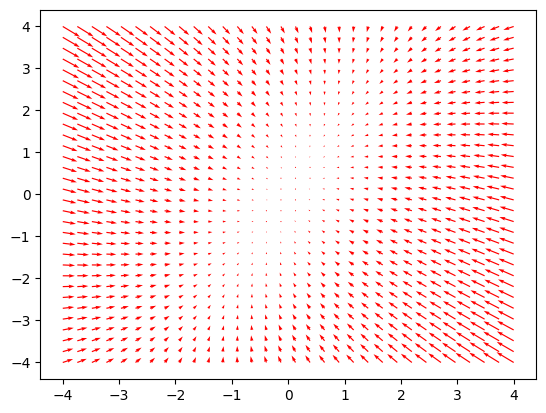

In [43]:
from jax.scipy.linalg import solve
from jax import grad, vmap

def multivariate_gaussian_pdf(x, mu, sigma):
    d = len(mu)
    x_centered = x - mu
    return (
        (2 * jnp.pi) ** (-d / 2)
        * jnp.linalg.det(sigma) ** (-1 / 2)
        * jnp.exp(-0.5 * x_centered.T @ solve(sigma, x_centered))
    )

def multivariate_gaussian_score(x, mu, sigma):
    log_pdf = lambda x: jnp.log(multivariate_gaussian_pdf(x, mu, sigma))
    return grad(log_pdf)(x)

# 示例使用
mu = jnp.array([0.0, 0.0])
sigma = jnp.array([[1.0, 0.5], [0.5, 2.0]])
x = jnp.array([[0.5, 1.0], [1.0, 1.5], [1.5, 2.0]])

score_func = vmap(multivariate_gaussian_score, in_axes=(0, None, None))
scores = score_func(x, mu, sigma)

x,y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, sigma), in_axes=(0))(Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')

In [44]:
@partial(jax.jit, static_argnums=(2,3))
def update_step_multi_gaussian(key, state, sigma, sample_size, mu, Sigma):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.multivariate_normal(subkey, mu, Sigma, (sample_size,))
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
mu = jnp.array([0.0, 0.0])
Sigma = jnp.array([[1.0, 0.5], [0.5, 2.0]])
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_multi_gaussian(subkey,state, sigma, sample_size, mu, Sigma)
    if i % 1000 == 0:
        print(loss)

103.01434
99.14821
94.56686
102.29721
101.24579
103.63087
100.5718
97.420334
99.03493
99.64365


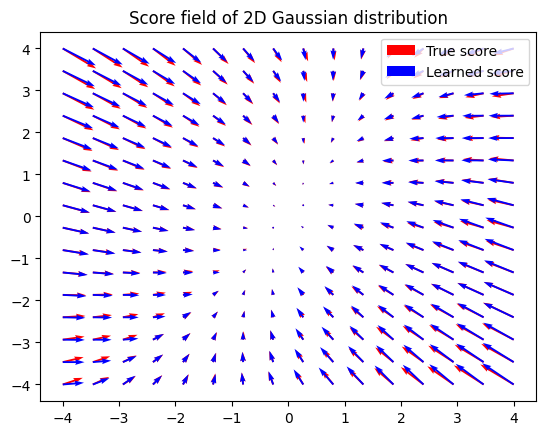

In [45]:
x,y = jnp.meshgrid(jnp.linspace(-4, 4, 16), jnp.linspace(-4, 4, 16))
Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, Sigma), in_axes=(0))(Z)
result_pred = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')
ax.quiver(Z[:, 0], Z[:, 1],result_pred[:, 0], result_pred[:, 1], color='b')
ax.legend(["True score", "Learned score"])
ax.set_title("Score field of 2D Gaussian distribution")
plt.show()

## 3. Do the DSM on the 3D Gaussian distribution

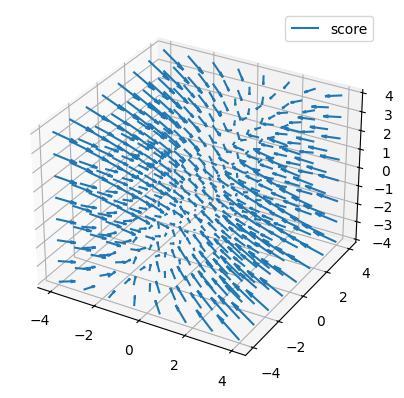

In [46]:
# 3D Gaussian distribution
def multivariate_gaussian_pdf(x, mu, sigma):
    d = len(mu)
    x_centered = x - mu
    return (
        (2 * jnp.pi) ** (-d / 2)
        * jnp.linalg.det(sigma) ** (-1 / 2)
        * jnp.exp(-0.5 * x_centered.T @ solve(sigma, x_centered))
    )

def multivariate_gaussian_score(x, mu, sigma):
    log_pdf = lambda x: jnp.log(multivariate_gaussian_pdf(x, mu, sigma))
    return grad(log_pdf)(x)

# 示例使用
mu = jnp.array([0.0, 0.0, 0.0])
sigma = jnp.array([[1.0, 0.5, 0.5], [0.5, 2.0, 0.5], [0.5, 0.5, 3.0]])
x = jnp.array([[0.5, 1.0, 1.5], [1.0, 1.5, 2.0], [1.5, 2.0, 2.5]])

score_func = vmap(multivariate_gaussian_score, in_axes=(0, None, None))
scores = score_func(x, mu, sigma)

x,y,z = jnp.meshgrid(jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8))
Z = jnp.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, sigma), in_axes=(0))(Z)
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result[:, 0], result[:, 1], result[:, 2], length=0.2)
ax.legend(["score"])
plt.show()

We can add the dim parameter to the MLP model to learn the 3D distribution.

In [47]:
class Onestep_score_MLP(nn.Module):
    @nn.compact
    def __call__(self, x, dim):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=dim)(x)
        x = nn.leaky_relu(x)
        
        return x
    
# the init_train_state_onestep function should be modified to add the dim parameter
def init_train_state_onestep(key, model, x, dim) ->train_state.TrainState:
    params = model.init(key, x, dim=dim)
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

In [48]:
@partial(jax.jit, static_argnums=(2,3,6))
def update_step_multi_gaussian(key, state, sigma, sample_size, mu, Sigma,dim):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.multivariate_normal(subkey, mu, Sigma, (sample_size,))
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x, dim)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 3)), dim=3)
sigma = 0.1
sample_size = 500
mu = jnp.array([0.0, 0.0, 0.0])
Sigma = jnp.array([[1.0, 0.5, 0.5], [0.5, 2.0, 0.5], [0.5, 0.5, 3.0]])
for i in range(20000):
    subkey = key_gen()
    state, loss = update_step_multi_gaussian(subkey,state, sigma, sample_size, mu, Sigma, 3)
    if i % 1000 == 0:
        print(loss)

147.87845
142.95247
146.64723
142.41095
152.13506
163.3629
154.88394
146.75464
143.11842
141.26233
149.04163
152.5498
147.67226
136.9987
152.23454
147.2537
140.15773
143.56079
148.76004
147.59752


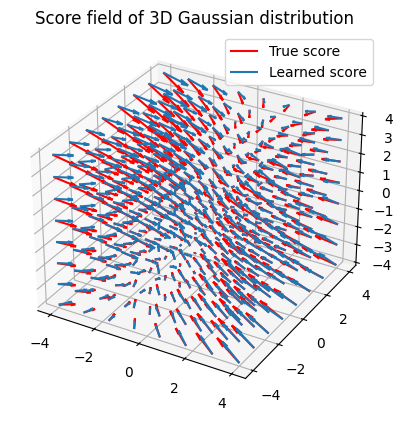

In [49]:
x,y,z = jnp.meshgrid(jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8))
Z = jnp.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, Sigma), in_axes=(0))(Z)
result_pred = jax.vmap(lambda x: state.apply_fn(state.params, x, 3), in_axes=(0))(Z)
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result[:, 0], result[:, 1], result[:, 2], length=0.2, color='r')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result_pred[:, 0], result_pred[:, 1], result_pred[:, 2], length=0.2)
ax.legend(["True score", "Learned score"])
ax.set_title("Score field of 3D Gaussian distribution")
plt.show()

## 4. Score matching in a stochastic process

We will simulate the stochastic process in 2 ways: One is from the noise adding perspective, the other is from the Stochastic Differential Equation(SDE) perspective.
